# The algorithm

<b>Input</b>:<br>
	$\quad\quad$ none<br>
<b>Algorithm parameter</b>:<br>
	$\quad\quad$ discount factor $\gamma$<br>
	$\quad\quad$ step size $\alpha \in (0,1]$<br>
	$\quad\quad$ small $\epsilon > 0$<br><br>

<b>FOR EACH</b> episode<br>
	$\quad$ $\mathbf{s} \leftarrow \text{env.reset}()$<br>
	$\quad$ <b>DO</b> <br>
		$\quad\quad$ $\mathbf{a} \leftarrow \epsilon\text{-greedy}(\mathbf{s}, \hat{Q}_{\mathbf{\omega}}$ $)$<br>
		$\quad\quad$ $r, \mathbf{s'} \leftarrow \text{env.step}(\mathbf{a})$<br>
		$\quad\quad$ $y \leftarrow
		\begin{cases}
			r & \text{for terminal } \mathbf{s'}\\
			r + \gamma \max_{\mathbf{a}^\star \in A} \hat{Q}_{\mathbf{\omega}}(\mathbf{s'})_{\mathbf{a}^\star} & \text{for non-terminal } \mathbf{s'}
		\end{cases}$<br>
		$\quad\quad$ $\mathbf{\omega} \leftarrow \mathbf{\omega} + \alpha \left[ y - \hat{Q}_{\mathbf{\omega}}(\mathbf{s})_{\mathbf{a}} \right] ~ \nabla_{\mathbf{\omega}} \hat{Q}_{\mathbf{\omega}}(\mathbf{s})_{\mathbf{a}}$ <br>
		$\quad\quad$ $\mathbf{s} \leftarrow \mathbf{s'}$ <br>
	$\quad$ <b>UNTIL</b> $\mathbf{s}$ is final<br><br>
<b>RETURN</b> $\mathbf{\omega}$ <br>

---


## Import

In [31]:
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
from tqdm.notebook import tqdm # pour les barres de progression
import random # pour epsilon greedy

import collections # pour le relay buffer
from typing import Callable, cast, List, Tuple, Union
import itertools

In [32]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.path.dirname('../qoridor'))))


from qoridor.game import QoridorGame
from qoridor.move import Move, MoveType
from qoridor.board import WallOrientation
from qoridor.visualization import QoridorVisualizer
from agents.random_agent import RandomAgent
from qoridor.environment import QoridorEnv

In [33]:
game = QoridorGame(board_size=5, num_walls=3)
visualizer = QoridorVisualizer()

In [34]:
game.state.get_observation()

{'board_size': 5,
 'player_positions': {1: (0, 2), 2: (4, 2)},
 'walls_left': {1: 3, 2: 3},
 'horizontal_walls': array([[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]]),
 'vertical_walls': array([[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]]),
 'current_player': 1,
 'done': False,
 'winner': None}

## State to vector

In [35]:
def state_to_vector(state):
    """Converts the state to a vector representation.

    Args:
        state (_type_): _description_
    """
    player_1_pos = state.get_observation()['player_positions'][1] # tuple (x,y)
    player_2_pos = state.get_observation()['player_positions'][2] # tuple (x,y)
    walls_1 = state.get_observation()['walls_left'][1]  #int
    walls_2 = state.get_observation()['walls_left'][2] #int
    current_player = state.get_observation()['current_player'] # 1 ou 2 
    horizontal_walls = state.get_observation()['horizontal_walls'].astype(int) # matrice (N-1)*(N-1) avec bit de présence
    vertical_walls = state.get_observation()['vertical_walls'].astype(int) # matrice (N-1)*(N-1) avec bit de présence

    state_vector = np.array([player_1_pos[0],player_1_pos[1],player_2_pos[0],player_2_pos[1],walls_1,walls_2,current_player])

    horizontal_walls_vector = horizontal_walls.flatten()
    vertical_walls_vector = vertical_walls.flatten()

    full_state_vector = np.concatenate((state_vector,horizontal_walls_vector,vertical_walls_vector))

    return full_state_vector




In [36]:
state_to_vector(game.state)

array([0, 2, 4, 2, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Q-Network

<div class="alert alert-block alert-warning">  
<b> Warning :</b> We could discuss the architecture of the network (fully connected, CNN etc)
</div>

In [37]:
class QNetwork(torch.nn.Module):
    """
    A Q-Network implemented with PyTorch.

    Attributes
    ----------
    layer1 : torch.nn.Linear
        First fully connected layer.
    layer2 : torch.nn.Linear
        Second fully connected layer.
    layer3 : torch.nn.Linear
        Third fully connected layer.

    Methods
    -------
    forward(x: torch.Tensor) -> torch.Tensor
        Define the forward pass of the QNetwork.
    """

    def __init__(self, n_observations: int, n_actions: int, nn_l1: int, nn_l2: int):
        """
        Initialize a new instance of QNetwork.

        Parameters
        ----------
        n_observations : int
            The size of the observation space.
        n_actions : int
            The size of the action space.
        nn_l1 : int
            The number of neurons on the first layer.
        nn_l2 : int
            The number of neurons on the second layer.
        """
        super(QNetwork, self).__init__()
        self.layer1 = torch.nn.Linear(n_observations, nn_l1)
        self.layer2 = torch.nn.Linear(nn_l1, nn_l2)
        self.layer3 = torch.nn.Linear(nn_l2, n_actions)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Define the forward pass of the QNetwork.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor (state).

        Returns
        -------
        torch.Tensor
            The output tensor (Q-values).
        """
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        output_tensor = self.layer3(x) # linear activation = no activation function



        return output_tensor

## Epsilon Greedy

In [38]:
class EpsilonGreedy:
    """
    An Epsilon-Greedy policy.

    Attributes
    ----------
    epsilon : float
        The initial probability of choosing a random action.
    epsilon_min : float
        The minimum probability of choosing a random action.
    epsilon_decay : float
        The decay rate for the epsilon value after each action.
    env : ????
    q_network : torch.nn.Module
        The Q-Network used to estimate action values.

    Methods
    -------
    __call__(state: np.ndarray) -> np.int64
        Select an action for the given state using the epsilon-greedy policy.
    decay_epsilon()
        Decay the epsilon value after each action.
    """

    def __init__(
        self,
        epsilon_start: float,
        epsilon_min: float,
        epsilon_decay: float,
        env: QoridorEnv,
        q_network: torch.nn.Module,
    ):
       
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.env = env
        self.q_network = q_network

    def __call__(self, state: np.ndarray) -> np.int64:



        if random.random() < self.epsilon:

            action = self.env.get_legal_actions()
            action = random.choice(action)
        else:
            with torch.no_grad():
                action = self.env.get_legal_actions()
                state_tensor = torch.tensor(state_to_vector(state), dtype=torch.float32).unsqueeze(0)
                q_values = self.q_network(state_tensor)
                q_values = [q_values[0][i].item() if i in action else -np.inf for i in range(len(q_values[0]))] 
                action = torch.argmax(torch.tensor(q_values)).item()

        return action

    def decay_epsilon(self):
        """
        Decay the epsilon value after each episode.

        The new epsilon value is the maximum of `epsilon_min` and the product of the current
        epsilon value and `epsilon_decay`.
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


<div class="alert alert-block alert-warning">  
<b> Warning :</b> We need to check more the env.step and change the rewards (for the moment : +1 if victory -1 if loss)
</div>

In [39]:
class ReplayBuffer:
    """
    A Replay Buffer.

    Attributes
    ----------
    buffer : collections.deque
        A double-ended queue where the transitions are stored.

    Methods
    -------
    add(state: np.ndarray, action: np.int64, reward: float, next_state: np.ndarray, done: bool)
        Add a new transition to the buffer.
    sample(batch_size: int) -> Tuple[np.ndarray, float, float, np.ndarray, bool]
        Sample a batch of transitions from the buffer.
    __len__()
        Return the current size of the buffer.
    """

    def __init__(self, capacity: int):
        """
        Initializes a ReplayBuffer instance.

        Parameters
        ----------
        capacity : int
            The maximum number of transitions that can be stored in the buffer.
        """
        self.buffer: collections.deque = collections.deque(maxlen=capacity)

    def add(
        self,
        state: np.ndarray,
        action: np.int64,
        reward: float,
        next_state: np.ndarray,
        done: bool,
    ):
        """
        Add a new transition to the buffer.

        Parameters
        ----------
        state : np.ndarray
            The state vector of the added transition.
        action : np.int64
            The action of the added transition.
        reward : float
            The reward of the added transition.
        next_state : np.ndarray
            The next state vector of the added transition.
        done : bool
            The final state of the added transition.
        """
        self.buffer.append((state, action, reward, next_state, done))

    def sample(
        self, batch_size: int
    ) -> Tuple[np.ndarray, Tuple[int], Tuple[float], np.ndarray, Tuple[bool]]:
        """
        Sample a batch of transitions from the buffer.

        Parameters
        ----------
        batch_size : int
            The number of transitions to sample.

        Returns
        -------
        Tuple[np.ndarray, float, float, np.ndarray, bool]
            A batch of `batch_size` transitions.
        """
        # Here, `random.sample(self.buffer, batch_size)`
        # returns a list of tuples `(state, action, reward, next_state, done)`
        # where:
        # - `state`  and `next_state` are numpy arrays
        # - `action` and `reward` are floats
        # - `done` is a boolean
        #
        # `states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))`
        # generates 5 tuples `state`, `action`, `reward`, `next_state` and `done`, each having `batch_size` elements.
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.array(states), actions, rewards, np.array(next_states), dones

    def __len__(self):
        """
        Return the current size of the buffer.

        Returns
        -------
        int
            The current size of the buffer.
        """
        return len(self.buffer)

In [40]:
from agents.random_agent import RandomAgent

## Train_dqn

In [41]:
def train_dqn2_agent(
    env: QoridorEnv, #! 
    q_network: torch.nn.Module,
    target_q_network: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    loss_fn: Callable,
    epsilon_greedy: EpsilonGreedy,
    device: torch.device,
    lr_scheduler: torch.optim.lr_scheduler.LRScheduler,
    num_episodes: int,
    gamma: float,
    batch_size: int,
    replay_buffer: ReplayBuffer,
    target_q_network_sync_period: int,
) -> List[float]:
    """
    Train the Q-network on the given environment.

    Parameters
    ----------
    env : #! ???
        The environment to train on.
    q_network : torch.nn.Module
        The Q-network to train.
    target_q_network : torch.nn.Module
        The target Q-network to use for estimating the target Q-values.
    optimizer : torch.optim.Optimizer
        The optimizer to use for training.
    loss_fn : callable
        The loss function to use for training.
    epsilon_greedy : EpsilonGreedy
        The epsilon-greedy policy to use for action selection.
    device : torch.device
        The device to use for PyTorch computations.
    lr_scheduler : torch.optim.lr_scheduler.LRScheduler
        The learning rate scheduler to adjust the learning rate during training.
    num_episodes : int
        The number of episodes to train for.
    gamma : float
        The discount factor for future rewards.
    batch_size : int
        The size of the batch to use for training.
    replay_buffer : ReplayBuffer
        The replay buffer storing the experiences with their priorities.
    target_q_network_sync_period : int
        The number of episodes after which the target Q-network should be updated with the weights of the Q-network.

    Returns
    -------
    List[float]
        A list of cumulated rewards per episode.
    """

    opponent = RandomAgent()


    iteration = 0
    episode_reward_list = []

    for episode_index in tqdm(range(1, num_episodes)):
        env.reset()
        state = env.game.state
        state_vector = state_to_vector(state)
        episode_reward = 0.0

        for t in itertools.count():
            # We suppose the agent dqn to be player 1
            if env.game.state.get_observation()['current_player'] == 1:
                action = epsilon_greedy(state) # epsilon greedy transform le game state en state vector

                _ , reward, done, info = env.step(action) # step return (observation, reward, done, {steps : self.steps})
                next_state = env.game.state
                next_state_vector = state_to_vector(next_state)

                replay_buffer.add(state_vector, action, float(reward), next_state_vector, done) # on lui donne le state vector et non le game state

                episode_reward += float(reward)

                # Update the q_network weights with a batch of experiences from the buffer

                if len(replay_buffer) > batch_size:
                    batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = replay_buffer.sample(batch_size)

                    # Convert to PyTorch tensors
                    batch_states_tensor = torch.tensor(np.array(batch_states, dtype=np.float32), dtype=torch.float32, device=device)
                    batch_actions_tensor = torch.tensor(np.array(batch_actions, dtype=np.int64), dtype=torch.long, device=device)
                    batch_rewards_tensor = torch.tensor(np.array(batch_rewards, dtype=np.float32), dtype=torch.float32, device=device)
                    batch_next_states_tensor = torch.tensor(np.array(batch_next_states, dtype=np.float32), dtype=torch.float32, device=device)
                    batch_dones_tensor = torch.tensor(np.array(batch_dones, dtype=bool), dtype=torch.bool, device=device)


                    # Convertir le tenseur booléen en un tenseur d'entiers (bug sinon sur le 1-batch_dones_tensor)
                    batch_dones_tensor = batch_dones_tensor.int()

                                    # Vérifier les dimensions des tenseurs
                    # print("batch_states_tensor shape:", batch_states_tensor.shape)
                    # print("batch_actions_tensor shape:", batch_actions_tensor.shape)
                    # print("batch_rewards_tensor shape:", batch_rewards_tensor.shape)
                    # print("batch_next_states_tensor shape:", batch_next_states_tensor.shape)
                    # print("batch_dones_tensor shape:", batch_dones_tensor.shape)


                    # Compute the target Q values for the batch
                    with torch.no_grad():
                        #! we had different implementation of the following in our labs.
                        next_state_q_values = target_q_network(batch_next_states_tensor)
                        best_action_index = torch.argmax(next_state_q_values, dim=1, keepdim=True) #! à contrôler
                        targets = batch_rewards_tensor + (1 - batch_dones_tensor) * gamma * next_state_q_values.gather(1, best_action_index).squeeze(1)
                    current_q_values = q_network(batch_states_tensor) #! à contrôler
                    # print("current_q_values shape:", current_q_values.shape)
                    # print("targets shape:", targets.shape)
                    # print("batch_actions_tensor.unsqueeze(1) shape:", batch_actions_tensor.unsqueeze(1).shape)
                    
                    loss = loss_fn(current_q_values.gather(1, batch_actions_tensor.unsqueeze(1)).squeeze(1), targets) #! à contrôler

                    # Optimize the model
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    lr_scheduler.step()

                # Update the target network
                if iteration % target_q_network_sync_period == 0:
                    target_q_network.load_state_dict(q_network.state_dict())
                iteration += 1

                if done:
                    break

                state = next_state
            
            else :
                # It's the turn of the opponent
                move = opponent.get_move(env.game)
                action = env._move_to_action(move)
                _ , reward, done, info = env.step(action)
                state = env.game.state
                state_vector = state_to_vector(state)

                if done:
                    break

        episode_reward_list.append(episode_reward)
        epsilon_greedy.decay_epsilon()

    return episode_reward_list



# Scheduler

In [42]:
class MinimumExponentialLR(torch.optim.lr_scheduler.ExponentialLR):
    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        lr_decay: float,
        last_epoch: int = -1,
        min_lr: float = 1e-6,
    ):
        """
        Initialize a new instance of MinimumExponentialLR.

        Parameters
        ----------
        optimizer : torch.optim.Optimizer
            The optimizer whose learning rate should be scheduled.
        lr_decay : float
            The multiplicative factor of learning rate decay.
        last_epoch : int, optional
            The index of the last epoch. Default is -1.
        min_lr : float, optional
            The minimum learning rate. Default is 1e-6.
        """
        self.min_lr = min_lr
        super().__init__(optimizer, lr_decay, last_epoch=-1)

    def get_lr(self) -> List[float]:
        """
        Compute learning rate using chainable form of the scheduler.

        Returns
        -------
        List[float]
            The learning rates of each parameter group.
        """
        return [
            max(base_lr * self.gamma**self.last_epoch, self.min_lr)
            for base_lr in self.base_lrs
        ]

# training

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [44]:
env = QoridorEnv(5,3)

NUMBER_OF_TRAININGS = 5  # Change the default (global) value here if you want a specific number of trainings for this exercise
dqn2_trains_result_list: List[List[Union[int, float]]] = [[], [], []] 

for train_index in range(NUMBER_OF_TRAININGS):
    # Instantiate required objects
    observation_dim = 7 + (env.board_size-1)**2 * 2
    num_actions = env.action_space_size

    q_network = QNetwork(observation_dim, num_actions, nn_l1=256, nn_l2=128).to(device)
    target_q_network = QNetwork(observation_dim, num_actions, nn_l1=256, nn_l2=128).to(device)
    target_q_network.load_state_dict(q_network.state_dict())
    optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.004, amsgrad=True)
    # lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
    loss_fn = torch.nn.MSELoss()

    epsilon_greedy = EpsilonGreedy(
        epsilon_start=1,
        epsilon_min=0.01,
        epsilon_decay=0.996,
        env=env,
        q_network=q_network,
    )

    replay_buffer = ReplayBuffer(2000)

    # Train the q-network

    episode_reward_list = train_dqn2_agent(
        env,
        q_network,
        target_q_network,
        optimizer,
        loss_fn,
        epsilon_greedy,
        device,
        lr_scheduler,
        num_episodes=150, #! to be changed
        gamma=0.9,
        batch_size=128,
        replay_buffer=replay_buffer,
        target_q_network_sync_period=30,
    )
    dqn2_trains_result_list[0].extend(range(len(episode_reward_list)))
    dqn2_trains_result_list[1].extend(episode_reward_list)
    dqn2_trains_result_list[2].extend([train_index for _ in episode_reward_list])

dqn2_trains_result_df = pd.DataFrame(
    np.array(dqn2_trains_result_list).T,
    columns=["num_episodes", "mean_final_episode_reward", "training_index"],
)
dqn2_trains_result_df["agent"] = "DQN 2013"

# Save the action-value estimation function

torch.save(q_network, "Test_dqn.pth")

env.close()

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

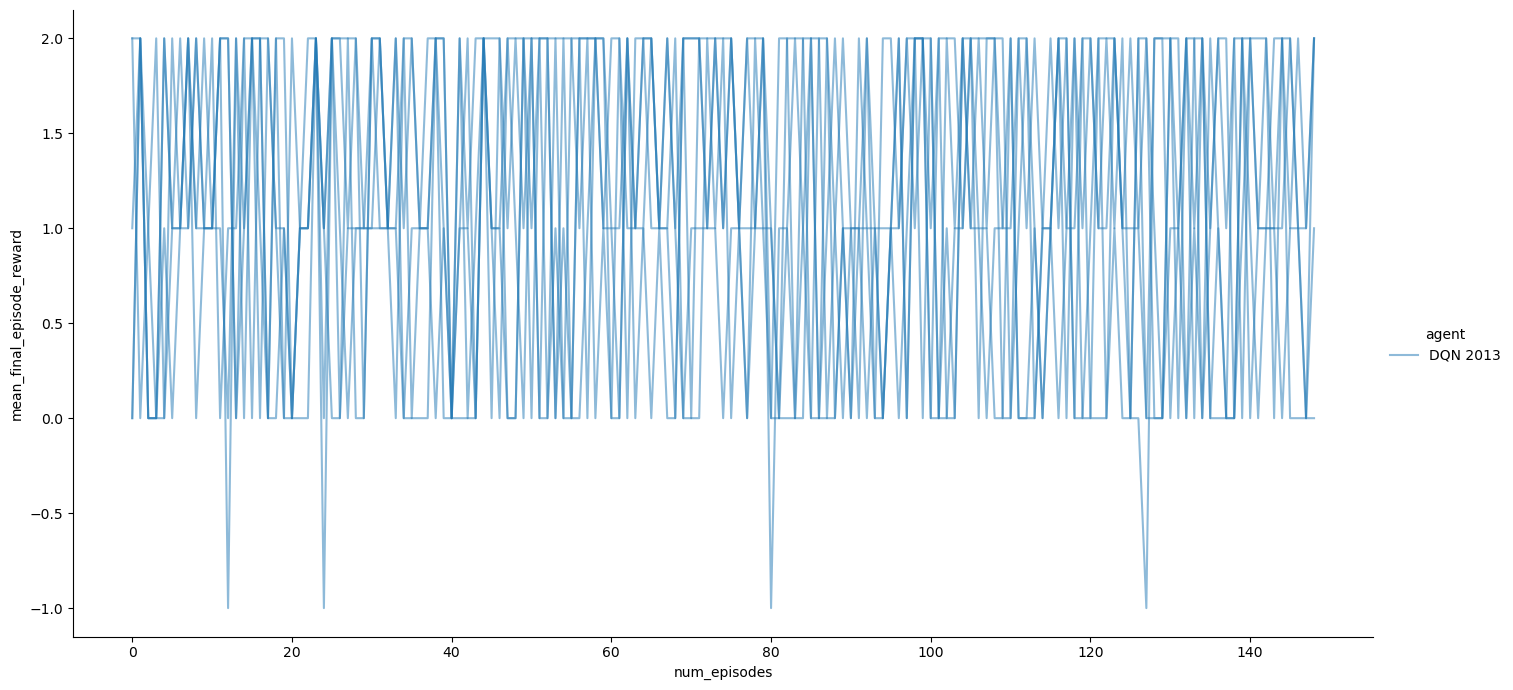

In [45]:
g = sns.relplot(
    x="num_episodes",
    y="mean_final_episode_reward",
    kind="line",
    hue="agent",
    estimator=None,
    units="training_index",
    data=dqn2_trains_result_df,
    height=7,
    aspect=2,
    alpha=0.5,
)

In [46]:
def select_action(state: np.ndarray, q_network: torch.nn.Module) -> int:
    """
    Select the action with the highest Q-value for the given state.
    
    Args:
        state: The current state as a numpy array.
        q_network: The trained Q-network.
        
    Returns:
        The action index with the highest Q-value.
    """
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        q_values = q_network(state_tensor)
        action = torch.argmax(q_values, dim=1).item()
    return action

Tour 1
L'agent joue
L'agent choisi l'action : 1, correspondant au move : Player 1 moves to (0, 1)
Tour 2


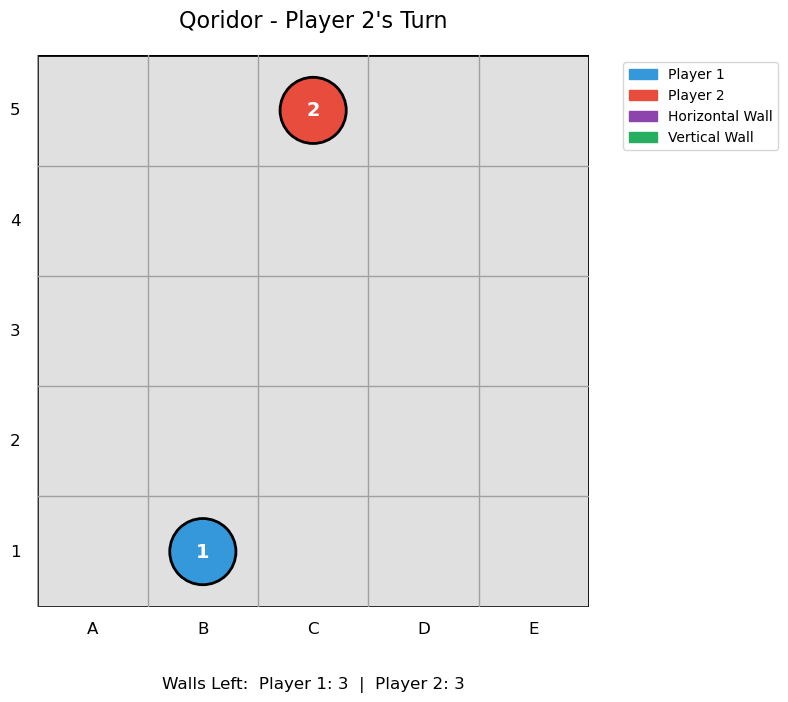

0: Player 2 moves to (3, 2)
1: Player 2 moves to (4, 1)
2: Player 2 moves to (4, 3)
3: Player 2 places horizontal wall at (0, 0)
4: Player 2 places horizontal wall at (0, 1)
5: Player 2 places horizontal wall at (0, 2)
6: Player 2 places horizontal wall at (0, 3)
7: Player 2 places horizontal wall at (1, 0)
8: Player 2 places horizontal wall at (1, 1)
9: Player 2 places horizontal wall at (1, 2)
10: Player 2 places horizontal wall at (1, 3)
11: Player 2 places horizontal wall at (2, 0)
12: Player 2 places horizontal wall at (2, 1)
13: Player 2 places horizontal wall at (2, 2)
14: Player 2 places horizontal wall at (2, 3)
15: Player 2 places horizontal wall at (3, 0)
16: Player 2 places horizontal wall at (3, 1)
17: Player 2 places horizontal wall at (3, 2)
18: Player 2 places horizontal wall at (3, 3)
19: Player 2 places vertical wall at (0, 0)
20: Player 2 places vertical wall at (0, 1)
21: Player 2 places vertical wall at (0, 2)
22: Player 2 places vertical wall at (0, 3)
23: Player 

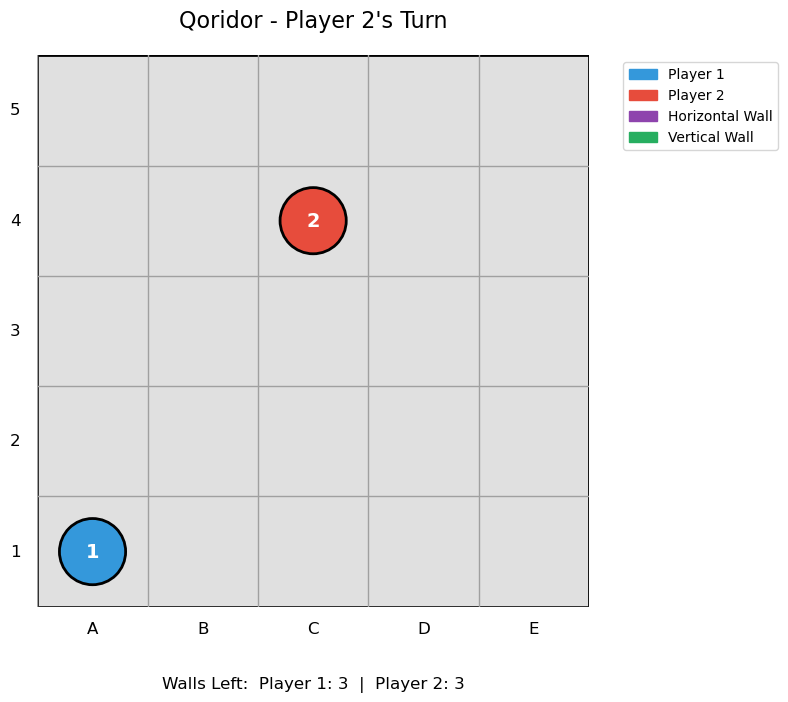

0: Player 2 moves to (4, 2)
1: Player 2 moves to (2, 2)
2: Player 2 moves to (3, 1)
3: Player 2 moves to (3, 3)
4: Player 2 places horizontal wall at (0, 0)
5: Player 2 places horizontal wall at (0, 1)
6: Player 2 places horizontal wall at (0, 2)
7: Player 2 places horizontal wall at (0, 3)
8: Player 2 places horizontal wall at (1, 0)
9: Player 2 places horizontal wall at (1, 1)
10: Player 2 places horizontal wall at (1, 2)
11: Player 2 places horizontal wall at (1, 3)
12: Player 2 places horizontal wall at (2, 0)
13: Player 2 places horizontal wall at (2, 1)
14: Player 2 places horizontal wall at (2, 2)
15: Player 2 places horizontal wall at (2, 3)
16: Player 2 places horizontal wall at (3, 0)
17: Player 2 places horizontal wall at (3, 1)
18: Player 2 places horizontal wall at (3, 2)
19: Player 2 places horizontal wall at (3, 3)
20: Player 2 places vertical wall at (0, 0)
21: Player 2 places vertical wall at (0, 1)
22: Player 2 places vertical wall at (0, 2)
23: Player 2 places vertic

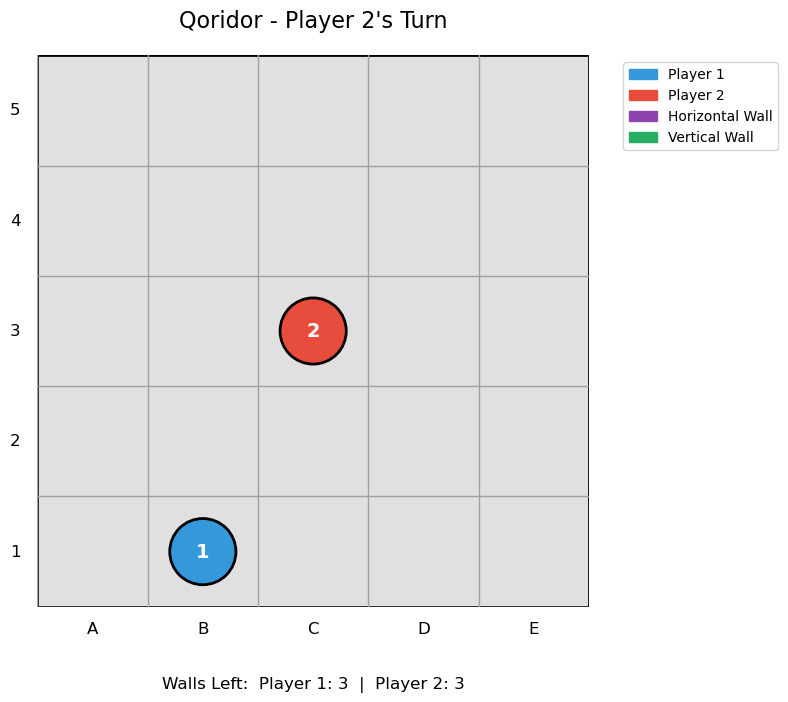

0: Player 2 moves to (3, 2)
1: Player 2 moves to (1, 2)
2: Player 2 moves to (2, 1)
3: Player 2 moves to (2, 3)
4: Player 2 places horizontal wall at (0, 0)
5: Player 2 places horizontal wall at (0, 1)
6: Player 2 places horizontal wall at (0, 2)
7: Player 2 places horizontal wall at (0, 3)
8: Player 2 places horizontal wall at (1, 0)
9: Player 2 places horizontal wall at (1, 1)
10: Player 2 places horizontal wall at (1, 2)
11: Player 2 places horizontal wall at (1, 3)
12: Player 2 places horizontal wall at (2, 0)
13: Player 2 places horizontal wall at (2, 1)
14: Player 2 places horizontal wall at (2, 2)
15: Player 2 places horizontal wall at (2, 3)
16: Player 2 places horizontal wall at (3, 0)
17: Player 2 places horizontal wall at (3, 1)
18: Player 2 places horizontal wall at (3, 2)
19: Player 2 places horizontal wall at (3, 3)
20: Player 2 places vertical wall at (0, 0)
21: Player 2 places vertical wall at (0, 1)
22: Player 2 places vertical wall at (0, 2)
23: Player 2 places vertic

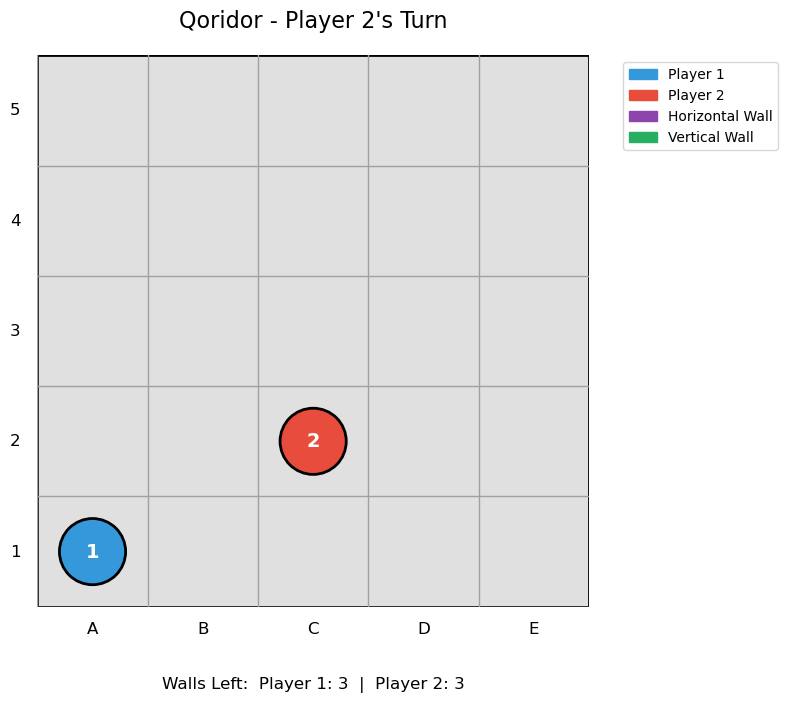

0: Player 2 moves to (2, 2)
1: Player 2 moves to (0, 2)
2: Player 2 moves to (1, 1)
3: Player 2 moves to (1, 3)
4: Player 2 places horizontal wall at (0, 0)
5: Player 2 places horizontal wall at (0, 1)
6: Player 2 places horizontal wall at (0, 2)
7: Player 2 places horizontal wall at (0, 3)
8: Player 2 places horizontal wall at (1, 0)
9: Player 2 places horizontal wall at (1, 1)
10: Player 2 places horizontal wall at (1, 2)
11: Player 2 places horizontal wall at (1, 3)
12: Player 2 places horizontal wall at (2, 0)
13: Player 2 places horizontal wall at (2, 1)
14: Player 2 places horizontal wall at (2, 2)
15: Player 2 places horizontal wall at (2, 3)
16: Player 2 places horizontal wall at (3, 0)
17: Player 2 places horizontal wall at (3, 1)
18: Player 2 places horizontal wall at (3, 2)
19: Player 2 places horizontal wall at (3, 3)
20: Player 2 places vertical wall at (0, 0)
21: Player 2 places vertical wall at (0, 1)
22: Player 2 places vertical wall at (0, 2)
23: Player 2 places vertic

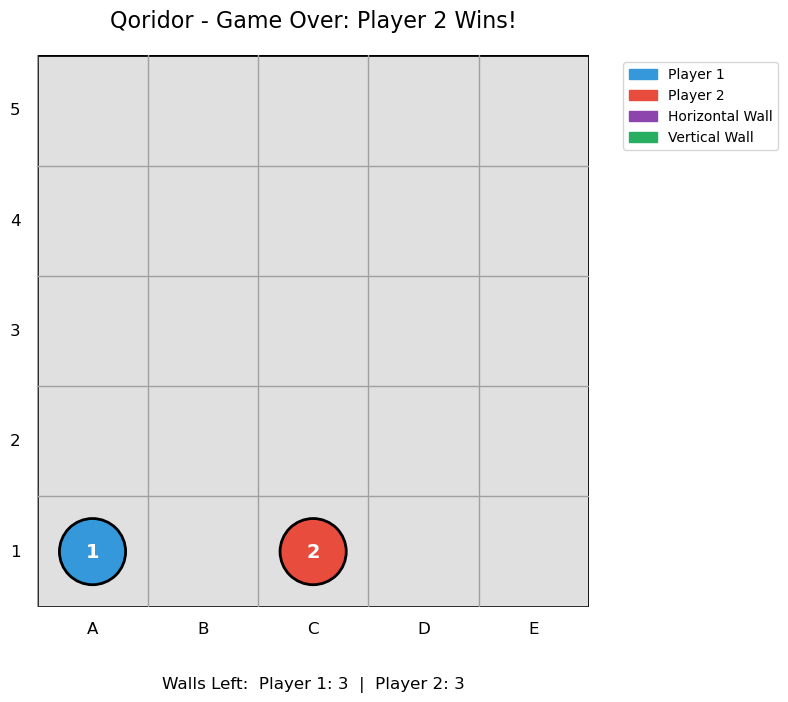

Winner : 2


In [53]:
env = QoridorEnv(5, 3)
visualizer = QoridorVisualizer()
q_network = torch.load('Test_dqn.pth')

tour = 1
while not env.game.is_game_over():
    print(f"Tour {tour}")
    state = env.game.state
    state_vector = state_to_vector(state)
    
    if env.game.state.get_observation()['current_player'] == 1:
        print("L'agent joue")
        action = select_action(state_vector, q_network)
        possible_moves = env.game.get_legal_moves()
        print(f"L'agent choisi l'action : {action}, correspondant au move : {possible_moves[action]}")
        env.game.make_move(possible_moves[action])
    else:
        visualizer.render_game(env.game)
        possible_moves = env.game.get_legal_moves()
        for idx, move in enumerate(possible_moves):
            print(f"{idx}: {move}")
        move_index = int(input("Entrez l'index du mouvement à jouer : "))
        print(f"Vous avez joué l'action : {move_index} correspondant au move {possible_moves[move_index]}")
        env.game.make_move(possible_moves[move_index])

    if env.game.is_game_over():
        break

    tour += 1

winner = env.game.get_winner()
visualizer.render_game(env.game)
print(f"Winner : {winner}")